# Manipulating raster/vector data with geoutils

**geoutils** was developed by glaciologists (R. Hugonnet, E. Mannerfelt, A. Dehecq), to make it easier to handle raster and vector data in Python.\
**xDEM** uses all functionnalities of geoutils and add additional tools specific to working with DEMs. \
The full documentation can be found at: \
https://geoutils.readthedocs.io. \
https://xdem.readthedocs.io.

This tutorial highlights some basic functionalities of geoutils/xdem:
- read, write, reproject and display rasters and vectors
- calculate terrain attributes from DEMs (slope, aspect etc.)
- calculate difference of DEMs and basic statistics.

For more examples, check the examples gallery on both geoutils and xdem's documentation.

## Import the necessary modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import geoutils as gu
import xdem

## Download the sample data set (if not done already) - Should take a few seconds ###
The code comes with some data for showcasing the functionality, here two DEMs over Longyearbyen, Norway and glacier outlines over Svalbard. \
The files are already on disk, we only nned to find their location.

In [2]:
xdem.examples.download_longyearbyen_examples(overwrite=False)
print(xdem.examples.get_path("longyearbyen_ref_dem"))
print(xdem.examples.get_path("longyearbyen_tba_dem"))
print(xdem.examples.get_path("longyearbyen_glacier_outlines"))

/Users/adehecq/development/GlacioHack/xdem/examples/data/Longyearbyen/data/DEM_2009_ref.tif
/Users/adehecq/development/GlacioHack/xdem/examples/data/Longyearbyen/data/DEM_1990.tif
/Users/adehecq/development/GlacioHack/xdem/examples/data/Longyearbyen/data/glacier_mask/CryoClim_GAO_SJ_1990.shp


### **Side work:** Find these files on your computer and open them in QGIS.

## Read the two DEMs and glacier outlines for the region ###

Raster files (e.g. GeoTiff) can be loaded in one line with `gu.Raster(path_to_file)`.

In [3]:
dem_2009 = gu.Raster(xdem.examples.get_path("longyearbyen_ref_dem"))
dem_1990 = gu.Raster(xdem.examples.get_path("longyearbyen_tba_dem"))

### **Side work:** Run the same commands, but copy/paste the file path. Uncomment the lines below (remove the # symbol) and replace ... with the file path.

In [4]:
# dem_2009 = gu.Raster(...)
# dem_1990 = gu.Raster(...)

Vector files (e.g. ESRI shapefiles) can be loaded in one line with `gu.Vector(path_to_file)`.

In [5]:
outlines_1990 = gu.Vector(xdem.examples.get_path("longyearbyen_glacier_outlines"))

## Quickly visualize a raster
Since a Raster object comes with all atributes, it can be quickly plotted with its georeferencing information.

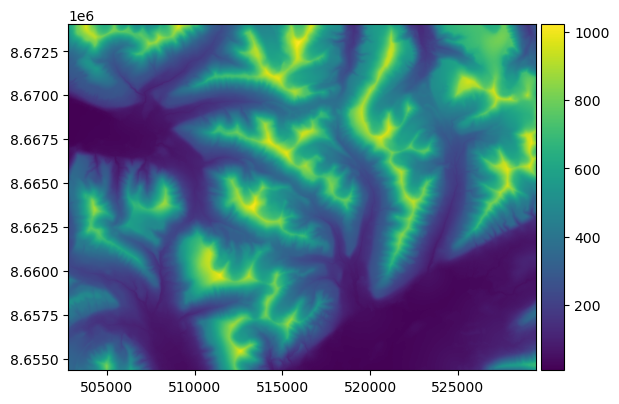

In [6]:
dem_2009.show()

It is easier to visualize as a hillshade

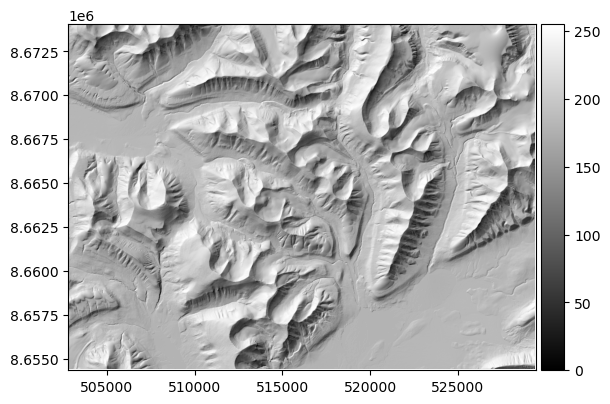

In [7]:
dem_2009_hs = xdem.terrain.hillshade(dem_2009)
dem_2009_hs.show(cmap='gray')

## Quickly visualize vector data

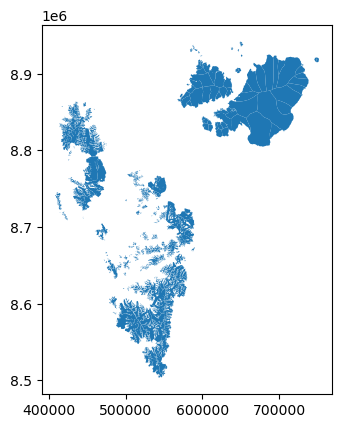

In [8]:
outlines_1990.show()

## Notes on the Raster and Vector classes

### The `geoutils.Raster` class is based upon **[rasterio](https://rasterio.readthedocs.io)** and inherits most of its metadata. 
These objects contain the raster metadata, with the same convention as rasterio. 
To georeference an object, one needs to know the coordinate reference system (called `crs` in rasterio/geopandas) and any 3 of these four information:
- the raster width and height
- the pixel resolution
- the extent of the raster (called `bounds` in rasterio/geopandas)
- the position of one pixel, traditionally, the upper-left \
These variables are inter-dependent, e.g. if one knows the raster's extent and width and height, the pixel resolution is fixed.
All these variables are stored in the `xdem.DEM` instance with the following attributes:

In [9]:
print(f"As PROJ4 string: {dem_2009.crs.to_proj4()}\n")
print(f"As WKT string: \n{dem_2009.crs.to_wkt()}")

As PROJ4 string: +init=epsg:25833

As WKT string: 
PROJCS["ETRS89 / UTM zone 33N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25833"]]


In [10]:
dem_2009.width

1332

In [11]:
dem_2009.height

985

In [12]:
dem_2009.res

(20.0, 20.0)

In [13]:
dem_2009.bounds

BoundingBox(left=502810.0, bottom=8654330.0, right=529450.0, top=8674030.0)

The resolution and position of the upper left pixel are traditionally stored in a so-called [transform](https://rasterio.readthedocs.io/en/latest/topics/transforms.html):

In [14]:
dem_2009.transform

Affine(20.0, 0.0, 502810.0,
       0.0, -20.0, 8674030.0)

These information, and more, can all be obtained **at once** with the command

In [15]:
print(dem_2009.info())

Driver:               GTiff 
Opened from file:     /Users/adehecq/development/GlacioHack/xdem/examples/data/Longyearbyen/data/DEM_2009_ref.tif 
Filename:             /Users/adehecq/development/GlacioHack/xdem/examples/data/Longyearbyen/data/DEM_2009_ref.tif 
Loaded?               True 
Modified since load?  False 
Size:                 1332, 985
Number of bands:      1
Data types:           ('float32',)
Coordinate System:    ['EPSG:25833']
NoData Value:         -9999.0
Pixel Size:           20.0, 20.0
Upper Left Corner:    502810.0, 8654330.0
Lower Right Corner:   529450.0, 8674030.0



Along with these metadata, the `xdem.DEM` object contains the data, stored as a numpy masked array in the `self.data` attribute:

In [16]:
dem_2009.data

masked_array(
  data=[[585.1568603515625, 593.7670288085938, 599.27587890625, ...,
         276.78131103515625, 287.1056823730469, 296.2648620605469],
        [585.667236328125, 594.3804321289062, 603.4343872070312, ...,
         276.9458923339844, 288.22772216796875, 298.573486328125],
        [584.7866821289062, 594.0465087890625, 602.7151489257812, ...,
         275.3355407714844, 285.9632263183594, 296.79010009765625],
        ...,
        [360.0013122558594, 359.192138671875, 358.2886657714844, ...,
         558.6853637695312, 561.381103515625, 565.4931640625],
        [360.65240478515625, 359.96295166015625, 359.01483154296875, ...,
         543.9490966796875, 546.5569458007812, 550.02880859375],
        [361.43194580078125, 360.63262939453125, 359.747802734375, ...,
         529.3741455078125, 532.504150390625, 537.7479248046875]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., 

### `gu.Vector` instances are based upon geopandas. 
The class contains several useful methods (`self.create_mask` is showcased below), and the GeoDataFrame can accessed via:

In [17]:
outlines_1990.ds

,NAME,Comment,IDENT,YEAR_,DDMM,SOURCE,ANALYST,YR_UNCERT,Shape_Area,FLAG,LENGTH,FWIDTH,Shape_Peri,geometry
0,Tindebreen,None,16107.0,1990,3107,Vertical aerial photograph,b'Max K\xf6nig',Exact day of photo aquisition not certain,1.077654e+06,0,2249.320430,257.496584,5904.870726,"POLYGON ((439199.970 8850128.111, 439211.020 8..."
1,b'Vestre Andr\xe9ebreen',None,16114.0,1990,3107,Vertical aerial photograph,b'Max K\xf6nig',Exact day of photo aquisition not certain,5.415100e+06,0,5434.124456,538.378473,13432.482627,"POLYGON ((448202.475 8847065.502, 448235.057 8..."
2,None,None,16113.0,1990,3107,Vertical aerial photograph,b'Max K\xf6nig',Exact day of photo aquisition not certain,6.749008e+05,0,1568.840403,184.097433,4651.214841,"POLYGON ((447999.467 8844946.655, 448029.065 8..."
3,Kvasspiggbreen,None,15801.0,1990,3107,Vertical aerial photograph,b'Max K\xf6nig',Exact day of photo aquisition not certain,2.474044e+06,0,2188.915410,653.981517,9019.472010,"POLYGON ((421605.655 8843053.060, 421602.140 8..."
4,Knattbreen,None,15723.0,1990,3107,Vertical aerial photograph,b'Max K\xf6nig',Exact day of photo aquisition not certain,2.735258e+06,0,3154.486785,364.844640,11232.537224,"POLYGON ((419471.886 8841789.259, 419483.147 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,Ringarbreane,None,13108.3,1990,3107,Vertical aerial photograph,Christopher Nuth,Exact day of photo aquisition not certain,9.576773e+05,0,1579.262328,282.046808,5739.966236,"POLYGON ((480263.106 8604978.244, 480266.172 8..."
1078,Ringarbreane,None,13108.1,1990,3107,Vertical aerial photograph,Christopher Nuth,Exact day of photo aquisition not certain,1.031565e+06,0,1818.931778,281.092459,5927.559794,"POLYGON ((478788.280 8606383.170, 478861.693 8..."
1079,None,None,11504.2,1990,3107,Vertical aerial photograph,Christopher Nuth,Exact day of photo aquisition not certain,6.416001e+05,0,1423.222427,196.457584,4033.809148,"POLYGON ((559457.505 8595826.170, 559439.851 8..."
1080,Greinebreane E,None,13604.1,1990,3107,Vertical aerial photograph,Christopher Nuth,Exact day of photo aquisition not certain,1.807680e+06,0,3371.559966,215.422235,12133.082971,"POLYGON ((525541.871 8648111.027, 525345.437 8..."


# Terrain attributes

**xDEM** enables calculating many terrain attributes: slope, aspect, hillshade, curbature etc. The full list is available here: https://xdem.readthedocs.io/en/stable/terrain.html

Here we will demonstrate a few of them.

### Slope

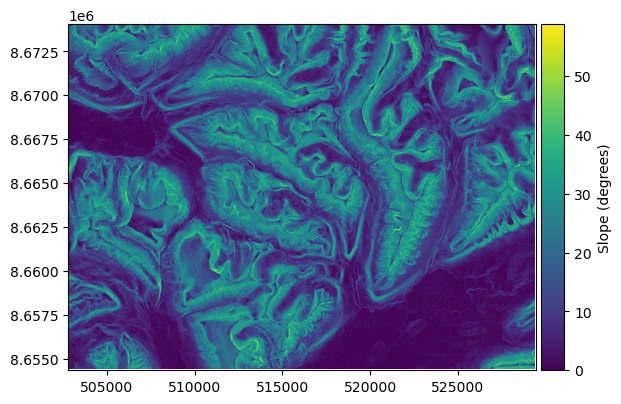

In [18]:
slope = xdem.terrain.slope(dem_1990)
slope.show(cbar_title="Slope (degrees)")

### Aspect

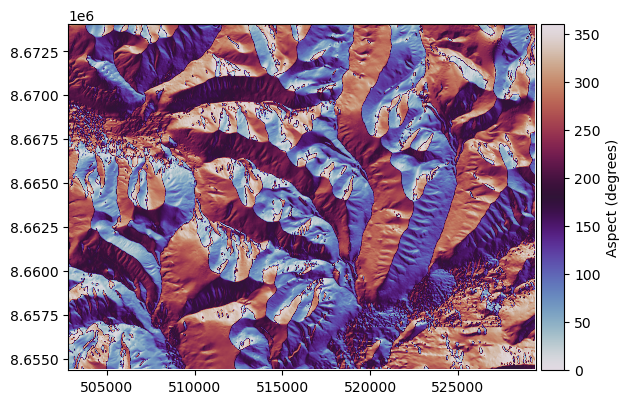

In [19]:
aspect = xdem.terrain.aspect(dem_1990)
aspect.show(cbar_title="Aspect (degrees)", cmap="twilight")

#### **Side work:** 
1) Plot the terrain rugosity
2) Calculate the maximum slope (using `np.max`)

In [20]:
# rugosity = xdem.terrain.???(dem_1990)
# rugosity.show(cbar_title="...", cmap="...")

In [21]:
# print("Maximum slope is:", np.max(...))

# Rasters operations

## Reproject the two DEMs on the same grid
Here the function returns a warning because the two DEMs are already on the same grid, so nothing is done.

In [22]:
dem_1990 = dem_1990.reproject(dst_ref=dem_2009)
print(dem_1990.info())
print(dem_2009.info())

Driver:               GTiff 
Opened from file:     /Users/adehecq/development/GlacioHack/xdem/examples/data/Longyearbyen/data/DEM_1990.tif 
Filename:             /Users/adehecq/development/GlacioHack/xdem/examples/data/Longyearbyen/data/DEM_1990.tif 
Loaded?               True 
Modified since load?  False 
Size:                 1332, 985
Number of bands:      1
Data types:           ('float32',)
Coordinate System:    ['EPSG:25833']
NoData Value:         -9999.0
Pixel Size:           20.0, 20.0
Upper Left Corner:    502810.0, 8654330.0
Lower Right Corner:   529450.0, 8674030.0

Driver:               GTiff 
Opened from file:     /Users/adehecq/development/GlacioHack/xdem/examples/data/Longyearbyen/data/DEM_2009_ref.tif 
Filename:             /Users/adehecq/development/GlacioHack/xdem/examples/data/Longyearbyen/data/DEM_2009_ref.tif 
Loaded?               True 
Modified since load?  False 
Size:                 1332, 985
Number of bands:      1
Data types:           ('float32',)
Coordinat

/Users/adehecq/development/GlacioHack/geoutils/geoutils/raster/raster.py:2108: UserWarning: Output projection, bounds and size are identical -> return self (not a copy!)
  warnings.warn("Output projection, bounds and size are identical -> return self (not a copy!)")


## Reproject to a given resolution, bounds, or CRS

#### Change pixel resolution

In [23]:
dem_test = dem_1990.reproject(dst_res=60)
print(dem_test.info())

Driver:               None 
Opened from file:     None 
Filename:             None 
Loaded?               True 
Modified since load?  True 
Size:                 444, 329
Number of bands:      1
Data types:           ('float32',)
Coordinate System:    ['EPSG:25833']
NoData Value:         -9999.0
Pixel Size:           60.0, 60.0
Upper Left Corner:    502810.0, 8654290.0
Lower Right Corner:   529450.0, 8674030.0



#### **Question:** What is the new raster height?

#### Change extent/bounds

In [24]:
dem_test = dem_1990.reproject(dst_bounds={"left":502810, "top":8674000, "right":529430, "bottom": 8654290})
print(dem_test.info())

Driver:               None 
Opened from file:     None 
Filename:             None 
Loaded?               True 
Modified since load?  True 
Size:                 1331, 986
Number of bands:      1
Data types:           ('float32',)
Coordinate System:    ['EPSG:25833']
NoData Value:         -9999.0
Pixel Size:           20.0, 19.989858012170384
Upper Left Corner:    502810.0, 8654290.0
Lower Right Corner:   529430.0, 8674000.0



#### **Question:** What is the new raster height?

#### Change Coordinate Reference System (CRS) i.e. projection

In [25]:
dem_test = dem_1990.reproject(dst_crs='epsg:4326')
print(dem_test.info())

Driver:               None 
Opened from file:     None 
Filename:             None 
Loaded?               True 
Modified since load?  True 
Size:                 1666, 257
Number of bands:      1
Data types:           ('float32',)
Coordinate System:    ['EPSG:4326']
NoData Value:         -9999.0
Pixel Size:           0.0006980470058920598, 0.0006980470058920598
Upper Left Corner:    15.120710653332189, 77.96090050488883
Lower Right Corner:   16.28365696514836, 78.14029858540309



#### **Question:** What is the new pixel resolution? What are the units?

## Reproject the outlines in the same coordinate system as DEMs

In [26]:
outlines_proj = outlines_1990.reproject(dst_crs=dem_2009.crs)

# Calculating the difference between two DEMs

In [27]:
ddem = dem_2009 - dem_1990

## Plot the elevation change map
#### Note: 
- `ax` is used here to share the same subplot between the raster and outlines (the default is to create a new figure)
- ddem is plotted last, to preserve the extent, as glacier outlines cover all of Svalbard.
- zorder is used to plot in the right sequence (outlines on top)

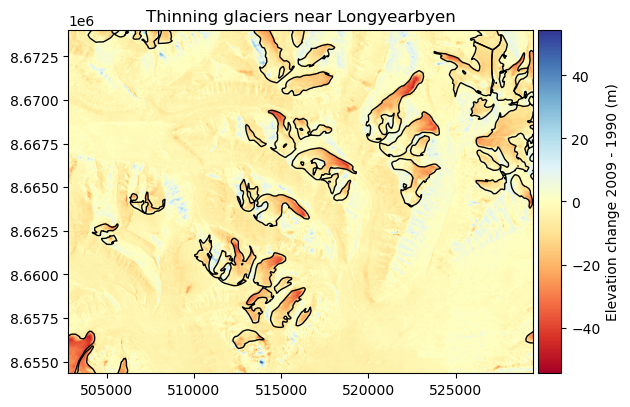

In [28]:
vmax = max(abs(np.max(ddem.data)), abs(np.min(ddem.data)))

ax = plt.subplot(111)
outlines_proj.show(ax=ax, facecolor='none', edgecolor='k', zorder=2)
ddem.show(ax=ax, cmap='RdYlBu', vmin=-vmax, vmax=vmax, cbar_title='Elevation change 2009 - 1990 (m)', zorder=1)
ax.set_title('Thinning glaciers near Longyearbyen')
plt.tight_layout()
plt.show()

#### **Side work:** Make changes to the plot: 
1) Plot the glacier outlines in red.
2) Use a different min/max value for colorscale.
3) Use a different colormap (choose among the list [here](https://matplotlib.org/stable/gallery/color/colormap_reference.html)).
4) Change the figure title.

(Uncomment the lines below and replace "..." with a different value)

In [29]:
# fig = plt.figure()
# ax = plt.subplot(111)
# outlines_proj.show(ax=ax, facecolor='none', edgecolor='...', zorder=2)
# ddem.show(ax=ax, cmap='coolwarm', vmin=..., vmax=..., cbar_title='Elevation change 2009 - 1990 (m)', zorder=1)
# ax.set_title('...')
# plt.tight_layout()
# plt.show()

## Saving the results

In [30]:
ddem.save("temp_ddem.tif")

# Calculate zonal statistics
Here we want to calculate the mean elevation change on and off glaciers.

## Rasterize the glacier outlines on the same grid as ddem
`glacier_mask` is `True` on glaciers, `False` elsewhere.

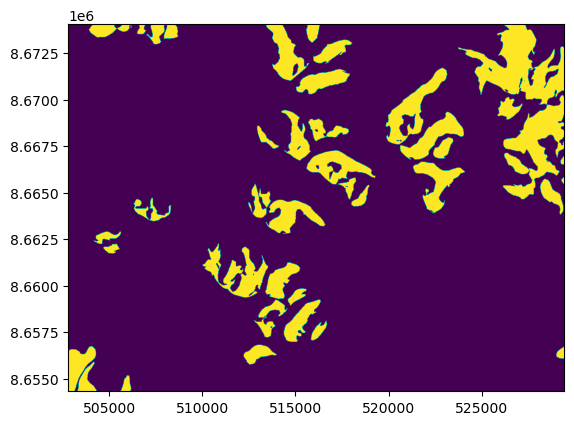

In [31]:
glacier_mask = outlines_1990.create_mask(ddem)
glacier_mask.show(add_cbar=False)

### Calculate mean dh over glaciers or stable terrain

Over glaciers:

In [32]:
print(np.mean(ddem[glacier_mask]))

-11.245888014916156


Over stable terrain

In [33]:
print(np.mean(ddem[~glacier_mask]))

-2.108906927134588


### Something is wrong, mean dh over stable terrain should be ~0 => we need to coregister the DEMs. This is some proper work for our next example !